# Phase 4 — Analysis, Scaling Trends, and Publication-Ready Tables

## Where we are vs the original roadmap
✅ **Phase 1**: instance generation (μ, Σ) and registry  
✅ **Phase 2**: QUBO construction + penalty sanity checks + saved `phase2_qubo_artifacts.json`  
✅ **Phase 3**: solver runs (Exact/SA/Tabu/(optional) QPU/Hybrid) + saved:
- `phase3_results.csv`
- `phase3_results_with_solutions.json` (richer metadata)

➡️ **Phase 4 (this notebook)**: aggregate results and produce:
- feasibility + constraint satisfaction
- quality vs baseline (gap to exact where available)
- scaling trends vs size `n` and tradeoff `q`
- (optional) QPU/HW metrics: chain breaks, timings (if present)
- clean tables + figures to drop into report/paper

This notebook is designed to be **robust**: it will still run even if you only have `phase3_results.csv`.


## 0) Imports

In [63]:
import os, json, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 1) Load Phase 3 artifacts (CSV + optional JSON)

In [64]:
PHASE3_CSV = "phase3_results_v2_qpu.csv"
PHASE3_JSON = "phase3_results_v2_qpu_with_solutions.json"  # optional but recommended

if not os.path.exists(PHASE3_CSV):
    raise FileNotFoundError(
        f"Missing {PHASE3_CSV}. Put this notebook in the same folder as Phase 3 outputs, "
        "or update PHASE3_CSV."
    )

df = pd.read_csv(PHASE3_CSV)
print("Loaded CSV rows:", len(df), "columns:", len(df.columns))

json_payload = None
if os.path.exists(PHASE3_JSON):
    with open(PHASE3_JSON, "r") as f:
        json_payload = json.load(f)
    print("Loaded JSON payload keys:", list(json_payload.keys())[:8])
else:
    print("Optional JSON not found; skipping QPU/Hybrid timing/chain-break deep dive.")

df.head()


Loaded CSV rows: 60 columns: 31
Loaded JSON payload keys: ['created_at', 'phase2_source', 'methods', 'rows']


,instance_key,method,engine,status,reason,n,B,q,A,runtime_s,E_best,E_best_improved,improve_engine,raw_sum_z,raw_feasible,raw_F_markowitz,raw_penalty,raw_E_qubo,imp_sum_z,imp_feasible,imp_F_markowitz,imp_penalty,imp_E_qubo,solver_info,time_limit,qpu_solver,used_embedding,chain_strength,num_reads,gap_F_imp_vs_exact,has_exact_ref
0,"(10, 5, 0.2, 'synthetic_factor', 2025)",exact,dimod.ExactSolver,ok,NaN,10,5,0.2,0.883501,0.004403,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True
1,"(10, 5, 0.2, 'synthetic_factor', 2025)",sa,neal.SA,ok,NaN,10,5,0.2,0.883501,0.905323,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True
2,"(10, 5, 0.2, 'synthetic_factor', 2025)",tabu,tabu,ok,NaN,10,5,0.2,0.883501,8.001940,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True
3,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_hybrid,dwave.Hybrid,ok,NaN,10,5,0.2,0.883501,14.182093,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,"{'qpu_access_time': 464508, 'charge_time': 999...",10.0,NaN,NaN,NaN,NaN,0.0,True
4,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_qpu,dwave.QPU,ok,NaN,10,5,0.2,0.883501,1.818084,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,"{'embedding_stats': {'mean_chain': 1.8, 'max_c...",NaN,Advantage_system4.1,FixedEmbeddingComposite(minorminer cached),2.73898,3000.0,0.0,True


## 2) Cleaning + helpers

In [65]:
def safe_literal_eval(x):
    if pd.isna(x):
        return None
    if isinstance(x, (dict, list)):
        return x
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

# Ensure numeric columns are numeric where expected
for col in ["n", "B", "q", "A", "runtime_s",
            "raw_F_markowitz", "imp_F_markowitz",
            "raw_penalty", "imp_penalty",
            "raw_E_qubo", "imp_E_qubo",
            "gap_F_raw_vs_exact", "gap_F_imp_vs_exact"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Ensure booleans
for col in ["raw_feasible", "imp_feasible", "has_exact_ref"]:
    if col in df.columns:
        df[col] = df[col].map(lambda v: bool(v) if isinstance(v, (bool, np.bool_)) else (str(v).lower()=="true"))

# Parse instance_key into components if possible
def parse_instance_key(key_str: str):
    try:
        t = ast.literal_eval(key_str)
        if isinstance(t, tuple) and len(t) >= 5:
            return {"n_key": int(t[0]), "B_key": int(t[1]), "q_key": float(t[2]), "kind_key": str(t[3]), "seed_key": int(t[4])}
    except Exception:
        return {"n_key": np.nan, "B_key": np.nan, "q_key": np.nan, "kind_key": None, "seed_key": np.nan}
    return {"n_key": np.nan, "B_key": np.nan, "q_key": np.nan, "kind_key": None, "seed_key": np.nan}

key_parts = df["instance_key"].apply(parse_instance_key).apply(pd.Series)
df = pd.concat([df, key_parts], axis=1)

print("Parsed key columns added.")
df.head()


Parsed key columns added.


,instance_key,method,engine,status,reason,n,B,q,A,runtime_s,E_best,E_best_improved,improve_engine,raw_sum_z,raw_feasible,raw_F_markowitz,raw_penalty,raw_E_qubo,imp_sum_z,imp_feasible,imp_F_markowitz,imp_penalty,imp_E_qubo,solver_info,time_limit,qpu_solver,used_embedding,chain_strength,num_reads,gap_F_imp_vs_exact,has_exact_ref,n_key,B_key,q_key,kind_key,seed_key
0,"(10, 5, 0.2, 'synthetic_factor', 2025)",exact,dimod.ExactSolver,ok,NaN,10,5,0.2,0.883501,0.004403,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True,10,5,0.2,synthetic_factor,2025
1,"(10, 5, 0.2, 'synthetic_factor', 2025)",sa,neal.SA,ok,NaN,10,5,0.2,0.883501,0.905323,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True,10,5,0.2,synthetic_factor,2025
2,"(10, 5, 0.2, 'synthetic_factor', 2025)",tabu,tabu,ok,NaN,10,5,0.2,0.883501,8.001940,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,NaN,NaN,NaN,NaN,NaN,NaN,0.0,True,10,5,0.2,synthetic_factor,2025
3,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_hybrid,dwave.Hybrid,ok,NaN,10,5,0.2,0.883501,14.182093,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,"{'qpu_access_time': 464508, 'charge_time': 999...",10.0,NaN,NaN,NaN,NaN,0.0,True,10,5,0.2,synthetic_factor,2025
4,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_qpu,dwave.QPU,ok,NaN,10,5,0.2,0.883501,1.818084,-22.088806,-22.088806,python.local_descent,5.0,True,-0.001275,0.0,-22.088806,5.0,True,-0.001275,0.0,-22.088806,"{'embedding_stats': {'mean_chain': 1.8, 'max_c...",NaN,Advantage_system4.1,FixedEmbeddingComposite(minorminer cached),2.73898,3000.0,0.0,True,10,5,0.2,synthetic_factor,2025


## 3) What ran, what skipped, and why

In [66]:
status_counts = (df.groupby(["method","status"])
                   .size()
                   .reset_index(name="count")
                   .sort_values(["method","status"]))
status_counts


,method,status,count
0,dwave_hybrid,ok,12
1,dwave_qpu,ok,9
2,dwave_qpu,skipped,3
3,exact,ok,6
4,exact,skipped,6
5,sa,ok,12
6,tabu,ok,12


## 4) Feasibility and constraint satisfaction

Interpretation:
- `*_feasible` checks **sum(z)=B**
- `*_penalty` should be **0** when feasible (because penalty is A*(sum(z)-B)^2)

If you see feasible=FALSE but penalty=0, that's a red flag (it shouldn’t happen).


In [67]:
ok = df[df["status"]=="ok"].copy()

feas_summary = (ok.groupby("method")
                .agg(
                    feasible_rate=("imp_feasible","mean"),
                    mean_penalty=("imp_penalty","mean"),
                    max_penalty=("imp_penalty","max"),
                    n_runs=("imp_feasible","size"),
                )
                .reset_index()
                .sort_values("feasible_rate", ascending=False))
feas_summary


,method,feasible_rate,mean_penalty,max_penalty,n_runs
0,dwave_hybrid,1.0,0.0,0.0,12
1,dwave_qpu,1.0,0.0,0.0,9
2,exact,1.0,0.0,0.0,6
3,sa,1.0,0.0,0.0,12
4,tabu,1.0,0.0,0.0,12


### Plot: feasibility rate by method

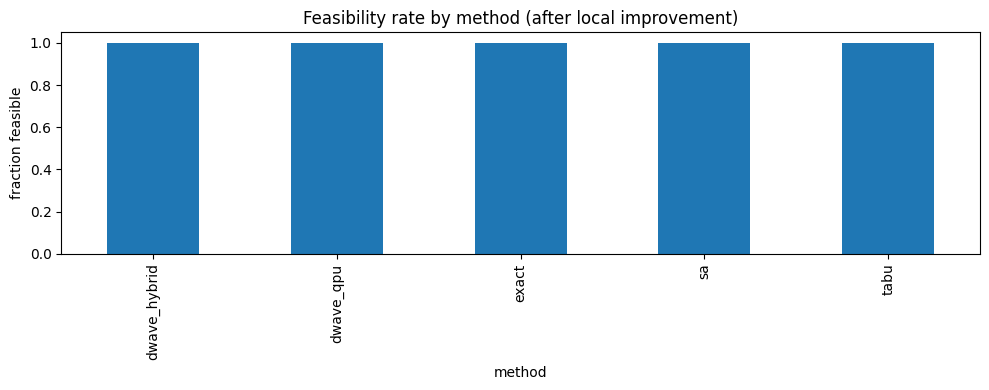

In [68]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
(ok.groupby("method")["imp_feasible"].mean().sort_values(ascending=False)
 .plot(kind="bar", ax=ax))
ax.set_title("Feasibility rate by method (after local improvement)")
ax.set_ylabel("fraction feasible")
plt.tight_layout()
plt.show()


## 5) Quality vs exact (when available)

When `exact` ran, it gives a gold-standard baseline for that instance.  
We use `gap_F_imp_vs_exact = imp_F_markowitz - exact_imp_F_markowitz`.

Lower is better. `0` means you matched exact.


In [69]:
ok_gap = ok[ok.get("has_exact_ref", False)].copy()
if len(ok_gap)==0:
    print("No exact references were recorded. (Did exact run? Is has_exact_ref present?)")
else:
    gap_non_exact = ok_gap[ok_gap["method"]!="exact"].copy()
    gap_non_exact[["instance_key","method","n","q","gap_F_imp_vs_exact","runtime_s","engine"]].head(10)


### Summary: gap by method and n

In [70]:
if "gap_F_imp_vs_exact" in ok.columns and "has_exact_ref" in ok.columns:
    gap_summary = (ok[ok["has_exact_ref"]]
                   .groupby(["method","n"])
                   .agg(
                       mean_gap=("gap_F_imp_vs_exact","mean"),
                       median_gap=("gap_F_imp_vs_exact","median"),
                       max_gap=("gap_F_imp_vs_exact","max"),
                       n_instances=("gap_F_imp_vs_exact","size"),
                   )
                   .reset_index()
                   .sort_values(["n","method"]))
    gap_summary
else:
    print("gap_F_imp_vs_exact missing. Re-run Phase 3 with gap computation enabled.")


### Plot: gap vs n (scatter)

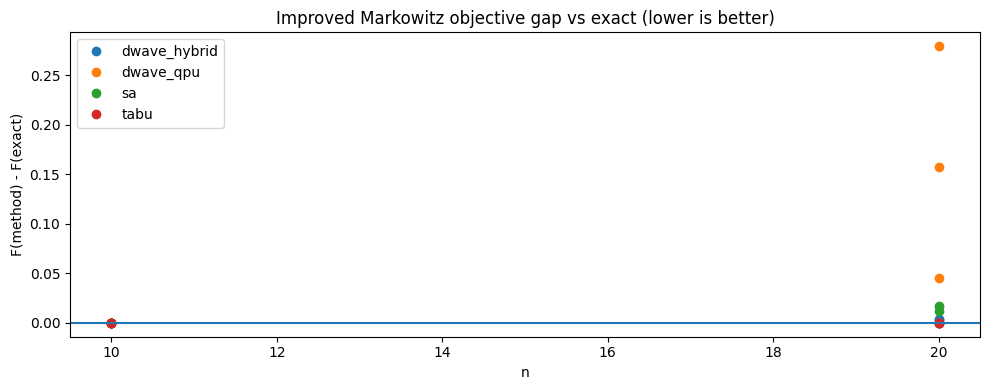

In [71]:
if "gap_F_imp_vs_exact" in ok.columns and "has_exact_ref" in ok.columns:
    df_gap = ok[(ok["method"]!="exact") & ok["has_exact_ref"] & ok["gap_F_imp_vs_exact"].notna()].copy()
    if len(df_gap) == 0:
        print("No non-exact rows with gap info.")
    else:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        for m in sorted(df_gap["method"].unique()):
            sub = df_gap[df_gap["method"]==m].sort_values("n")
            ax.plot(sub["n"], sub["gap_F_imp_vs_exact"], marker="o", linestyle="None", label=m)
        ax.axhline(0.0)
        ax.set_title("Improved Markowitz objective gap vs exact (lower is better)")
        ax.set_xlabel("n")
        ax.set_ylabel("F(method) - F(exact)")
        ax.legend()
        plt.tight_layout()
        plt.show()


## 6) Runtime scaling

In [72]:
runtime_summary = (ok.groupby(["method","n"])
                   .agg(mean_runtime_s=("runtime_s","mean"),
                        median_runtime_s=("runtime_s","median"),
                        n_runs=("runtime_s","size"))
                   .reset_index()
                   .sort_values(["n","method"]))
runtime_summary


,method,n,mean_runtime_s,median_runtime_s,n_runs
0,dwave_hybrid,10,13.471723,13.205096,3
4,dwave_qpu,10,1.682014,1.777197,3
7,exact,10,0.002469,0.001583,3
9,sa,10,0.965383,0.958756,3
13,tabu,10,8.001444,8.001614,3
1,dwave_hybrid,20,13.368671,13.275095,3
5,dwave_qpu,20,1.829707,1.820910,3
8,exact,20,1.282330,1.280636,3
10,sa,20,2.372687,2.400746,3
14,tabu,20,8.001605,8.001791,3


### Plot: runtime vs n (log y)

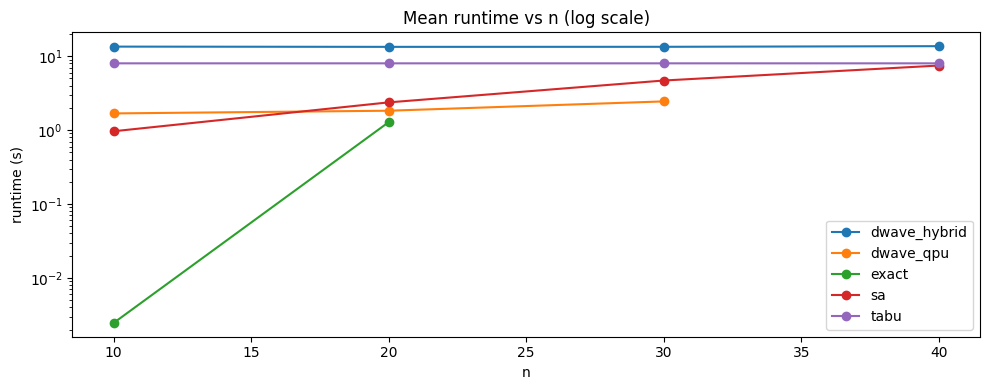

In [73]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
for m in sorted(ok["method"].unique()):
    sub = ok[ok["method"]==m].groupby("n")["runtime_s"].mean().reset_index().sort_values("n")
    ax.plot(sub["n"], sub["runtime_s"], marker="o", label=m)
ax.set_yscale("log")
ax.set_title("Mean runtime vs n (log scale)")
ax.set_xlabel("n")
ax.set_ylabel("runtime (s)")
ax.legend()
plt.tight_layout()
plt.show()


## 7) Did postprocessing help? (raw vs improved)

We compare improvement in QUBO energy and Markowitz objective:
- `raw_F_markowitz - imp_F_markowitz` (positive means improvement)
- `raw_E_qubo - imp_E_qubo`

Note: postprocessing optimizes QUBO energy locally; it should usually not worsen it.


In [74]:
if "raw_F_markowitz" in ok.columns and "imp_F_markowitz" in ok.columns:
    ok["delta_F"] = ok["raw_F_markowitz"] - ok["imp_F_markowitz"]
    ok["delta_E"] = ok["raw_E_qubo"] - ok["imp_E_qubo"]

    improv_summary = (ok.groupby("method")
                      .agg(
                          mean_delta_F=("delta_F","mean"),
                          frac_improved_F=("delta_F", lambda s: float(np.mean(s > 1e-12))),
                          mean_delta_E=("delta_E","mean"),
                          frac_improved_E=("delta_E", lambda s: float(np.mean(s > 1e-12))),
                          n_runs=("delta_F","size"),
                      )
                      .reset_index()
                      .sort_values("frac_improved_E", ascending=False))
    improv_summary
else:
    print("Missing raw/imp columns needed for improvement analysis.")


### Plot: distribution of delta_F by method

/var/folders/m4/rndkh84x7l7_zhb99lhzjcqw0000gn/T/ipykernel_6951/3681523618.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=methods)


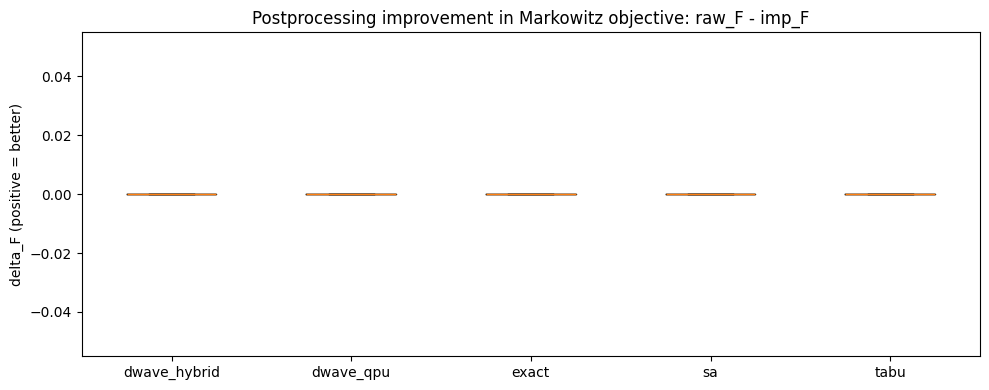

In [75]:
if "delta_F" in ok.columns:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,1,1)
    methods = sorted(ok["method"].unique())
    data = [ok[ok["method"]==m]["delta_F"].dropna().to_numpy() for m in methods]
    ax.boxplot(data, labels=methods)
    ax.set_title("Postprocessing improvement in Markowitz objective: raw_F - imp_F")
    ax.set_ylabel("delta_F (positive = better)")
    plt.tight_layout()
    plt.show()


## 8) Optional: QPU/Hybrid deep dive (only if present in JSON)

If you ran QPU/Hybrid in Phase 3, the JSON can contain nested fields like timing and chain breaks.
This section will only do work if such rows exist.


In [76]:
if json_payload is None:
    print("No JSON payload; skipping.")
else:
    rows = json_payload.get("rows", [])
    dfj = pd.DataFrame(rows)
    if len(dfj) == 0 or "engine" not in dfj.columns:
        print("JSON has no usable rows/engine column.")
    else:
        dfj["solver_info_dict"] = dfj["solver_info"].apply(safe_literal_eval) if "solver_info" in dfj.columns else None
        qpu_rows = dfj[dfj["engine"].astype(str).str.contains("dwave.QPU", na=False)].copy()
        hyb_rows = dfj[dfj["engine"].astype(str).str.contains("dwave.Hybrid", na=False)].copy()
        print("QPU rows:", len(qpu_rows), "Hybrid rows:", len(hyb_rows))

        def get_chain_break(d):
            if not isinstance(d, dict):
                return np.nan
            return d.get("chain_break_fraction", np.nan)

        if len(qpu_rows) > 0:
            qpu_rows["chain_break_fraction"] = qpu_rows["solver_info_dict"].map(get_chain_break)
            qpu_rows[["instance_key","method","engine","runtime_s","chain_break_fraction"]].head(10)
        else:
            print("No QPU rows found (likely not run).")


QPU rows: 9 Hybrid rows: 12


## 9) Export clean tables for your report/paper

In [77]:
OUT_SUMMARY_CSV = "phase4_runtime_by_method_n.csv"
OUT_FEAS_CSV = "phase4_feasibility_by_method.csv"
OUT_GAP_CSV = "phase4_gap_by_method_n.csv"

runtime_summary.to_csv(OUT_SUMMARY_CSV, index=False)
feas_summary.to_csv(OUT_FEAS_CSV, index=False)

if "gap_summary" in locals():
    gap_summary.to_csv(OUT_GAP_CSV, index=False)

print("Saved:", OUT_SUMMARY_CSV)
print("Saved:", OUT_FEAS_CSV)
if "gap_summary" in locals():
    print("Saved:", OUT_GAP_CSV)


Saved: phase4_runtime_by_method_n.csv
Saved: phase4_feasibility_by_method.csv
Saved: phase4_gap_by_method_n.csv


✅ Phase 4 complete.

Next (Phase 5): write the narrative (report / paper-style):
- problem definition + QUBO mapping
- experimental setup + solver configs
- results + key figures
- limitations + next steps (scaling, constraints, real data)
